<a href="https://www.kaggle.com/code/kendevoe/ell-deberta-v3-base?scriptVersionId=156903536" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports and Data Preparation

In [1]:
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import numpy as np # linear algebra
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import skew
import torch        # Import PyTorch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torch import nn
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm

#os.system('pip install iterative-stratification==0.1.7')
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [2]:
DEFAULT_FONT = 14

## Data Loading

In [3]:
# Load dataset
dataPath = '../input/feedback-prize-english-language-learning/train.csv'
df_all = pd.read_csv(dataPath)

# Create essay average scores to simplify dataset comparisons
categories = df_all.columns[2:8]
df_all['Average'] = df_all[categories].mean(axis=1).round(1)

## Data Splitting

In total 3911 graded essays were provided outside of the Kaggle competition test set. To compare performance across different models this dataset was split into training, validation and test sets.    

Splits were performed at 80/10/10 for Training, Validation and Test data respectively. Due to the small sample sizes average essay scores in all three datasets were compared to ensure both the validation and test set maintained a similar distribution to the training set.  

Overall no significant differences were seen after splitting, indicating further action such as stratified splitting was not necessary.


Summary of Averages for each dataset:


,Train,Validate,Test
count,3128.0,391.0,392.0
mean,3.1,3.1,3.1
std,0.6,0.5,0.6
min,1.0,1.0,1.4
25%,2.7,2.7,2.7
50%,3.1,3.1,3.1
75%,3.5,3.4,3.5
max,5.0,4.6,4.8


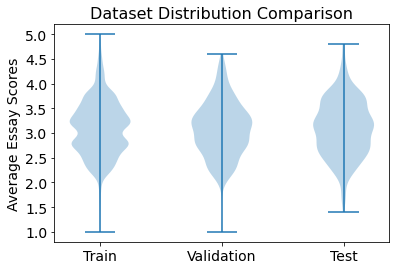

In [4]:
# Split data into Train, Validation and Test sets
df_train, df_holdout = train_test_split(
    df_all, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(
    df_holdout, test_size=0.5, random_state=42)

# Create summary of all three datasets
train_desc = df_train['Average'].describe()
val_desc = df_val['Average'].describe()
test_desc = df_test['Average'].describe()

summary = pd.concat([train_desc, val_desc, test_desc], axis=1)
summary.columns = ['Train', 'Validate', 'Test']

print("\nSummary of Averages for each dataset:")
pd.set_option('display.float_format', lambda x: '%0.1f' % x)
display(summary)

# Compare distributions of each dataset
plt.violinplot([df_train['Average'], df_val['Average'], df_test['Average']])
plt.yticks(fontsize=DEFAULT_FONT)
plt.xticks([1, 2, 3], ['Train', 'Validation', 'Test'], fontsize=DEFAULT_FONT)
plt.title("Dataset Distribution Comparison", fontsize=DEFAULT_FONT+2)
plt.ylabel("Average Essay Scores", fontsize=DEFAULT_FONT)
plt.show()

# Exploratory Data Analysis

## Missing Value Check
A check for missing input data or score values show no data points are missing. Missing input texts would need to be dropped and missing score values could potentitally be imputed using an algorithm such as KNN imputer.

In [5]:
print(df_train.isnull().sum())

text_id        0
full_text      0
cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
Average        0
dtype: int64


## Reviewing Random Samples
Random samples were pulled to examine some essays and scores. The number of characters displayed from each sample was limited to 1000 for formatting, however it can be adjusted with the MAX_DISPLAY variable.

In [6]:
MAX_DISPLAY = 1000 # max sample display length in characters
NUM_SAMPLES = 3    # Number of samples to display

samples = df_train.sample(NUM_SAMPLES, random_state=42)
for row, ind in enumerate(samples.index):
    print('-'*50)
    print(f"Sample {ind}\n\n", samples['full_text'][ind][:MAX_DISPLAY])
    display(samples.iloc[row][categories].to_frame().T)
    print() 

--------------------------------------------------
Sample 98

 The Curfews Keep Teenagers Out Of Trouble

Once, I walked down the empty street during midnight. Then, I heard a rising sound of a strange footstep behind me. Suddenly, I felt anxious and scared that someone might come up to me and murder me for money. Lucikly, there was nothing happened to me. After I got home, I had a thinking that what if a city council adopts a 10 P.M. weekday curfew and a midnight curfew for teenagers. If the curfew is published, any teenager who is wandering on the street after those hours would be violating the law. On the other hand, some might believe that the curfews unfairly interfere in young people's lives because it does not let the teenagers have their freedom and accomplish something that is very important to them, which they cannot do it another time. I still agree with the idea that curfews keep teenagers out of trouble because it stops teenagers from doing something that is illegal during

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
98,4.0,4.5,4.5,4.5,4.5,4.5



--------------------------------------------------
Sample 996

 Imagine someone that you know, that is trying to show you what maturity looks like. And she set a example for you to see, by how she talk and how she treats her friends and family. You watch how the person act and talk. Later, you start to follow what that person does. This influenced you to also be respectful to the people around you. Setting a good example by your own behavior is the best way to influence others because people follow what you do,know right from wrong, they are going to influence more other people.

First reason, setting a good example to influence others is the best thing because people follow what you do. They look up to you as a role model for them. Whoever you hang around with, that is whoever going to influence you. For example, if someone is doing a act of kindness, then you are going to do the exact same thing, because it influenced you. Philosopher Albert Schweitzer said," Example is not the main

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
996,3.5,3.0,3.5,3.0,2.5,3.5



--------------------------------------------------
Sample 3518

 They say that conserving energy and resources, some buissness have a four day work week consisting ten houres a day. Extending the school day two houres and a four day school week ain't a bad idea for people who need's more help and are focusing on their future and college. Do you think this is a great idea? Yes, because the more time your at school the more time you'll be learning and getting help. If added 2 more houres to school on a four day school week, the more school work will be finished and learned. I think my school should fallow this model because in my opinion test and quiz scores will show a greater improvement over time.

First reason why my school should have a four-day week school with a exteded 2 houres is because, many work can be done at school and teachers would have more time to explain details with deeper nolige. Teachers could have more time to study practice with the students before taking their t

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
3518,3.0,2.5,2.5,2.5,3.5,2.5


## Distribution by Category
Each category is centered between 3.0 - 3.2 for scores with a consistent standard deviation of 0.6 - 0.7 . All categories show a slight positive skew indicating a longer tail of values towards the maximum score of 5.0 .

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3128.0,3128.0,3128.0,3128.0,3128.0,3128.0
mean,3.1,3.0,3.2,3.1,3.0,3.1
std,0.7,0.6,0.6,0.7,0.7,0.7
min,1.0,1.0,1.0,1.0,1.0,1.0
25%,2.5,2.5,3.0,2.5,2.5,2.5
50%,3.0,3.0,3.0,3.0,3.0,3.0
75%,3.5,3.5,3.5,3.5,3.5,3.5
max,5.0,5.0,5.0,5.0,5.0,5.0


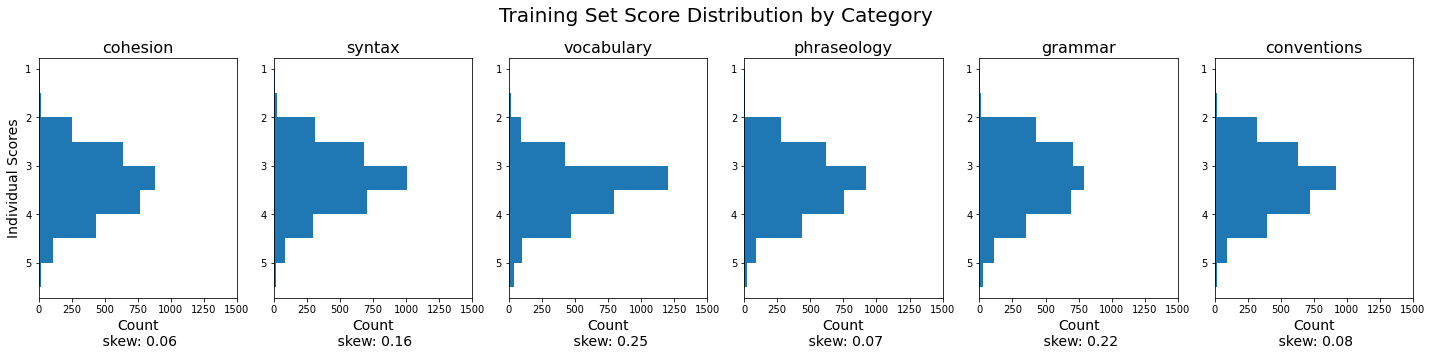

In [7]:
# Show statistics for each category
display(df_train[categories].describe())

# Generate histograms for each category
bins = [x / 2 for x in range(2, 12)]

fig, axs = plt.subplots(1, 6, figsize=(20, 5), tight_layout=True)
fig.suptitle('Training Set Score Distribution by Category', fontsize=DEFAULT_FONT + 6)

for i, axs in enumerate(fig.axes):
    skew_value = round(skew(df_train[categories[i]]), 2)
    axs.hist(df_train[categories[i]], bins=bins, orientation='horizontal')
    axs.set_title(categories[i], fontsize=DEFAULT_FONT + 2)
    if i == 0:
        axs.set_ylabel("Individual Scores", fontsize=DEFAULT_FONT)
    axs.set_xlim(0, 1500)
    axs.set_xlabel(f"Count\n skew: {skew_value}", fontsize=DEFAULT_FONT)
    axs.invert_yaxis()

## Token Lengths

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


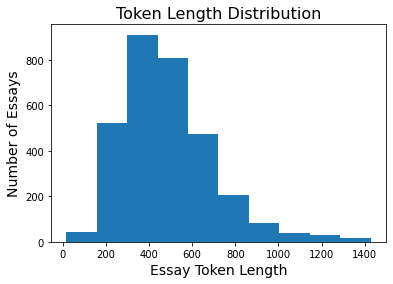

,0
count,3128.0
mean,485.8
std,212.2
min,16.0
25%,337.0
50%,453.5
75%,594.0
max,1428.0


In [8]:
MAX_CONTEXT = 768

# Calculate token lengths for each example
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')
input_tokens = tokenizer(df_train.full_text.tolist())
token_lengths = np.array([len(x) for x in input_tokens['input_ids']])

max_len = min(MAX_CONTEXT, max(token_lengths))  # Used for truncation during data loading

# Show distribution of token lengths
plt.hist(token_lengths)
plt.title("Token Length Distribution", fontsize=DEFAULT_FONT+2)
plt.xlabel("Essay Token Length", fontsize=DEFAULT_FONT)
plt.ylabel("Number of Essays", fontsize=DEFAULT_FONT)
plt.show()

display(pd.DataFrame(token_lengths).describe())

Comparison of essay length vs essay score. Main concern is the DebertaV3-base hidden size of 768 limits the length of essays that can be evaluated before truncation is used. 

Below the score distribution for essays that are not truncated (< 768 token length) are compared with essays that are truncated.

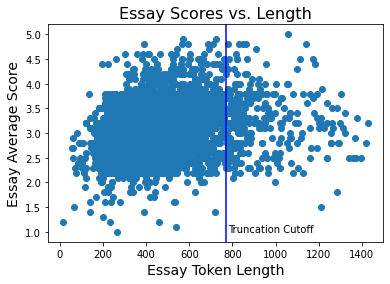

Out of 3128 essays 297 or 9.5% will be truncated.


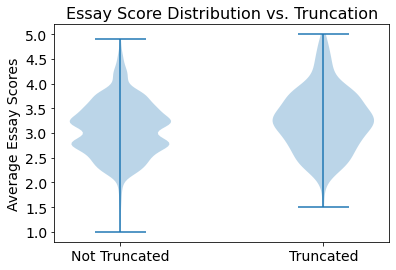

,Not Truncated,Truncated
count,2831.0,297.0
mean,3.1,3.3
std,0.6,0.6
min,1.0,1.5
25%,2.7,2.8
50%,3.1,3.2
75%,3.5,3.7
max,4.9,5.0


In [9]:
# Ratio of essays over token length limit


# Show token length vs average essay score
plt.scatter(token_lengths, df_train['Average'])
plt.title("Essay Scores vs. Length", fontsize=DEFAULT_FONT+2)
plt.xlabel("Essay Token Length", fontsize=DEFAULT_FONT)
plt.ylabel("Essay Average Score", fontsize=DEFAULT_FONT)
plt.axvline(x = MAX_CONTEXT, color = 'b', label = 'Truncation Cutoff')
plt.text(MAX_CONTEXT + 10, 1 ,'Truncation Cutoff',rotation=0)
plt.show()

# Compare score distributions for essays above and below length threshold
over_threshold = token_lengths > MAX_CONTEXT
within_threshold = token_lengths <= MAX_CONTEXT

print(f"Out of {len(token_lengths)} essays {np.count_nonzero(over_threshold)} \
or {np.count_nonzero(over_threshold)/len(token_lengths)*100:.1f}% will be truncated.")

not_truncated = np.array(df_train['Average'][within_threshold])
truncated = np.array(df_train['Average'][over_threshold])

# Compare distributions of each dataset
plt.violinplot([df_train['Average'][within_threshold], df_train['Average'][over_threshold]])
plt.yticks(fontsize=DEFAULT_FONT)
plt.xticks([1, 2], ['Not Truncated', 'Truncated'], fontsize=DEFAULT_FONT)
plt.title("Essay Score Distribution vs. Truncation", fontsize=DEFAULT_FONT+2)
plt.ylabel("Average Essay Scores", fontsize=DEFAULT_FONT)
plt.show()

not_trunc_desc = df_train['Average'][within_threshold].describe()
trunc_desc = df_train['Average'][over_threshold].describe()

trunc_summary = pd.concat([not_trunc_desc, trunc_desc], axis=1)
trunc_summary.columns = ['Not Truncated', 'Truncated']
display(trunc_summary)

In [10]:
#%%script false --no-raise-error

# Build the train dataset class
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self,df):
        df["combined"] = df[["cohesion", "syntax", "vocabulary",
                            "phraseology", "grammar", "conventions"]].apply(tuple, axis=1)
        self.labels = torch.tensor(df.combined.reset_index(drop=True))

        self.texts = [tokenizer(text, padding='max_length', max_length = max_len,
                               truncation=True, return_tensors="pt") for text in df['full_text']]
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        
        return self.texts[idx], self.labels[idx]

In [11]:
# Build the model

class DebertaEvaluator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.deberta = AutoModel.from_pretrained('microsoft/deberta-v3-base')
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(768, 6)
        
    def forward(self, input_id, mask):
        output = self.deberta(input_ids=input_id, attention_mask=mask)
        output_pooled = torch.mean(output.last_hidden_state, 1)
        dropout_output = self.dropout(output_pooled)
        linear_output = self.linear(dropout_output)
        
        return linear_output


In [12]:
#%%script false --no-raise-error

model = DebertaEvaluator()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# Save the base model parameters
base_model_path = '../working/base_model.pt'

torch.save(model.state_dict(), '../working/base_model.pt')

In [14]:
# Setting up the Layerwise Learning Rate Decay
# Adapted from: 
# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2022/03/29/discriminative-lr.html

def LR_Decay(model, lr=1e-3, lr_mult=0.7):
    
    # Save the layer names
    layer_names = []
    for idx, (name, param) in enumerate(model.named_parameters()):
        layer_names.append(name)
        #print(f'{idx}: {name}')
    
    layer_names.reverse()

    # Placeholder for parameters
    lr_parameters = []
    prev = [None]

    # Store params and learning rates
    for idx, name in enumerate(layer_names):
    
        name_sections = name.split('.')
        # Implement the stepper

        # Ignore the last linear layers
        if name_sections[0] == 'linear':
            #print("linear layer")
            pass

        # Do step at any changes to model sections
        elif name_sections[1] != prev[1]:
            lr *= lr_mult

        # Don't do any changes inside non-encoder layers
        elif name_sections[1] != 'encoder':
            pass
        
        # Make change if encoder layer type changes
        elif name_sections[2] != prev[2]:
            lr *= lr_mult
            
        # Don't make changes in encoder for non-layers
        elif name_sections[2] != 'layer':
            pass

        # Make change at each encoder layer type layer change
        elif name_sections[3] != prev[3]:
            lr *= lr_mult

        prev = name_sections

        # display info
        #print(f'{idx}: lr = {lr:.7f}, {name}')

        # append layer parameters
        lr_parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                       'lr': lr}]
        
    return lr_parameters

In [15]:
# Creating RMSE loss function

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        """
        y_pred.shape = (Batch, Column)
        y_true.shape = (Batch, Column)
        """
        loss = nn.functional.mse_loss(y_pred, y_true, reduction='none')
        loss = torch.sqrt(torch.mean(loss, dim=0))
        return torch.mean(loss).to(torch.float32)

In [16]:


# Setting up the device for training and/or inference

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device being used is: ", device)


Device being used is:  cuda


In [17]:
#%%script false --no-raise-error

# Move the model to device for training

model.to(device)

DebertaEvaluator(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (drop

# **Train Loop**

In [18]:
def generate_dataloaders(df_train, df_val, batch_size):
    
    train_dataset = Dataset(df_train)
    val_dataset = Dataset(df_val)
            
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, val_dataloader
    

In [19]:
def iterate(mode, dataloader, model, criterion, optimizer, batch_size, epoch, report_steps=50):
    total_loss = 0
    current_step = 0
    predictions = []
    labels = []

    # Perform training
    for input_data, label in tqdm(dataloader):

        mask = input_data['attention_mask'].to(device)
        input_id = input_data['input_ids'].squeeze(1).to(device)
        label = label.to(device)
        
        # Loss
        output = model(input_id, mask).squeeze(1)
        batch_loss = criterion(output, label.float())
        total_loss += batch_loss.item()

        if mode == "train":
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            current_step += 1

            if current_step % report_steps == 0:
                print(f'Training of Epoch {epoch + 1} {(current_step/len(dataloader)) * 100 : .1f}% complete')
                print(f'Sample batch loss at iteration {current_step * batch_size}: {batch_loss.item() : .3f}')
                
        labels = labels + label.tolist()
        predictions = predictions + output.tolist()
        
            
    return total_loss, labels, predictions

In [20]:
def save_results(results, hparams, train_loss, val_loss, epoch, path="../working/performance.csv"):
    # Add losses to output
    results[-2].append(train_loss)
    results[-1].append(val_loss)

    # Write output to outfile
    max_epochs = max([len(result) for result in results])

    train_val = ['train', 'val'] * hparams.shape[0]

    df_results = pd.DataFrame(results, columns = [x + 1 for x in range(max_epochs)])

    double_df = pd.DataFrame(np.repeat(hparams.values, 2, axis=0))
    double_df.columns = hparams.columns
    double_df.insert(loc=double_df.shape[1], column='Type', value=train_val)

    df_results = pd.concat([double_df, df_results], axis=1)

    df_results.to_csv('../working/performance.csv', index=False)

    # Print the results for the epoch
    print(f'Results Saved -- Epoch: {epoch + 1} | Train Loss: {train_loss: .3f} \
    | Val Loss: {val_loss : .3f}')
        

In [21]:
def plot_performance(labels, predictions, verbose=False,
                     categories=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']):
    MIN_VALUE = 1
    MAX_VALUE = 5
    
    df_pred = pd.DataFrame(predictions, columns = categories)
    df_labels = pd.DataFrame(labels, columns = categories)
    
    # Calculate average values
    df_pred['Average'] = df_pred[categories].mean(axis=1).round(1)
    df_labels['Average'] = df_labels[categories].mean(axis=1).round(1)
    
    # Plot average actual vs predicitons
    plt.scatter(df_labels['Average'], df_pred['Average'])
    plt.plot([MIN_VALUE, MAX_VALUE], [MIN_VALUE, MAX_VALUE], color='red')
    plt.legend(['Predictions', 'Perfect Correlation'])
    plt.title('Predicted vs. Actual Average Scores')
    plt.show()
    
    if verbose:
        for category in categories:
            plt.scatter(df_labels[category], df_pred[category])
            plt.plot([MIN_VALUE, MAX_VALUE], [MIN_VALUE, MAX_VALUE], color='red')
            plt.legend(['Predictions', 'Perfect Correlation'])
            plt.title(category)
            plt.show()
    

In [22]:
def plot_train_val(idx, results):
    train_idx = idx * 2
    val_idx = train_idx + 1
    
    plt.plot(results[train_idx], label="train")
    plt.plot(results[val_idx], label="validation")
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.legend(loc="upper right")
    plt.show()

In [23]:
#%%script false --no-raise-error

# Define model training scheme

def model_train(hparams, idx, results):
    
    # Print the current hyperparameter values
    print(hparams.iloc[idx])

    batch_size = int(hparams['batch_size'][idx])
    epochs = int(hparams['epochs'][idx])
    
     # Set the criterion, optimizer and learning rate
    lr_parameters = LR_Decay(model, hparams['lr_start'][idx], hparams['lr_decay'][idx])
    criterion = RMSELoss()
    optimizer = optim.Adam(lr_parameters)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=hparams['epoch_decay'][idx], verbose=False)

    # Load the base parameters for the model
    model.load_state_dict(torch.load(base_model_path))
    
    # Add 2 results layers for train and validation from this model
    for i in range(2):
        results.append([])

    train_dataloader, val_dataloader = generate_dataloaders(df_train, df_val, batch_size)
        
    for epoch in range(epochs):
            
        # Run Training
        print("Running Training")
        total_loss_train, train_labels, train_predictions = iterate("train", train_dataloader, 
                                                                        model, criterion, optimizer, 
                                                                        batch_size, epoch, report_steps=1000)
        # Run Validation
        print("Running Validation")
        with torch.no_grad():
            total_loss_val, val_labels, val_predictions = iterate("validation", val_dataloader, 
                                                                      model, criterion, optimizer,
                                                                      batch_size, epoch, report_steps=1000)
        print(val_labels[:50])
        print(df_val[categories].head(50))
        
        scheduler.step()
        plot_performance(val_labels, val_predictions)
        train_loss = total_loss_train / len(train_dataloader)
        val_loss = total_loss_val / len(val_dataloader)     
            
        save_results(results, hparams, train_loss, val_loss, epoch)
    
    #return results

Run            1.0
lr_start       0.0
lr_decay       1.0
epoch_decay    1.0
batch_size     8.0
dropout        0.0
epochs        10.0
Name: 0, dtype: float64
Running Training


100%|██████████| 391/391 [06:52<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

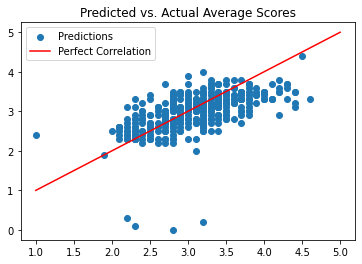

Results Saved -- Epoch: 1 | Train Loss:  0.749     | Val Loss:  0.638
Running Training


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

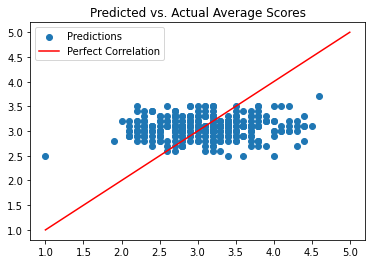

Results Saved -- Epoch: 2 | Train Loss:  0.649     | Val Loss:  0.710
Running Training


100%|██████████| 391/391 [06:52<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

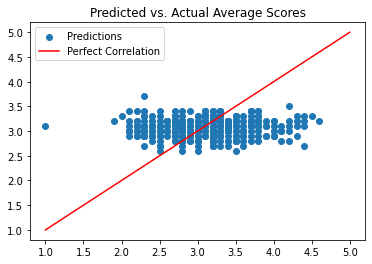

Results Saved -- Epoch: 3 | Train Loss:  0.722     | Val Loss:  0.688
Running Training


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

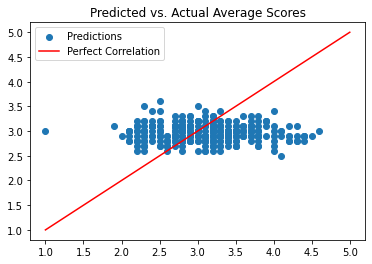

Results Saved -- Epoch: 4 | Train Loss:  0.707     | Val Loss:  0.694
Running Training


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

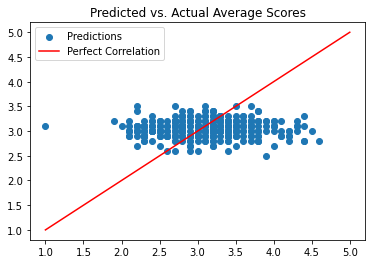

Results Saved -- Epoch: 5 | Train Loss:  0.698     | Val Loss:  0.672
Running Training


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

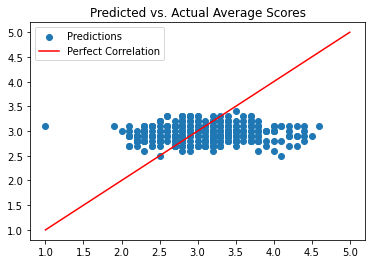

Results Saved -- Epoch: 6 | Train Loss:  0.693     | Val Loss:  0.678
Running Training


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

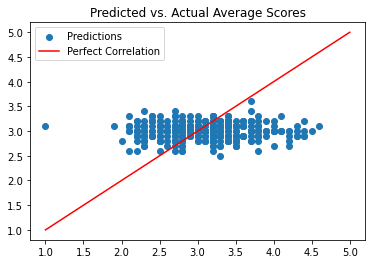

Results Saved -- Epoch: 7 | Train Loss:  0.687     | Val Loss:  0.674
Running Training


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

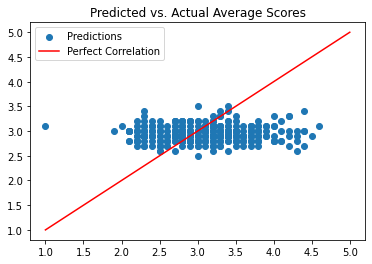

Results Saved -- Epoch: 8 | Train Loss:  0.688     | Val Loss:  0.672
Running Training


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

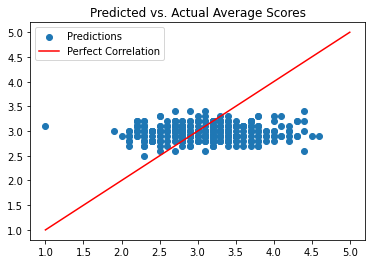

Results Saved -- Epoch: 9 | Train Loss:  0.680     | Val Loss:  0.673
Running Training


100%|██████████| 391/391 [06:51<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]

[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

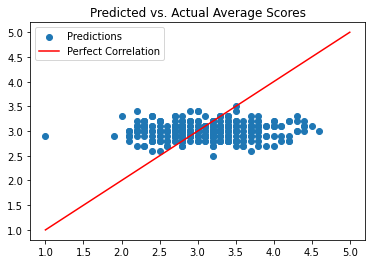

Results Saved -- Epoch: 10 | Train Loss:  0.683     | Val Loss:  0.661


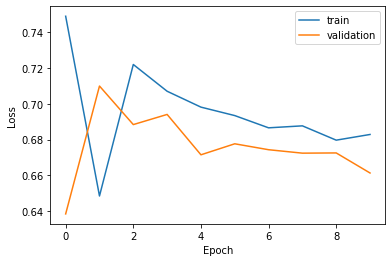

Run            2.0
lr_start       0.0
lr_decay       1.0
epoch_decay    1.0
batch_size     8.0
dropout        0.0
epochs        10.0
Name: 1, dtype: float64
Running Training


100%|██████████| 391/391 [06:52<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

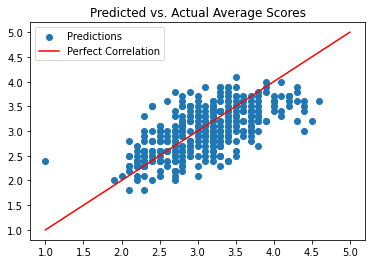

Results Saved -- Epoch: 1 | Train Loss:  0.741     | Val Loss:  0.628
Running Training


100%|██████████| 391/391 [06:52<00:00,  1.06s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

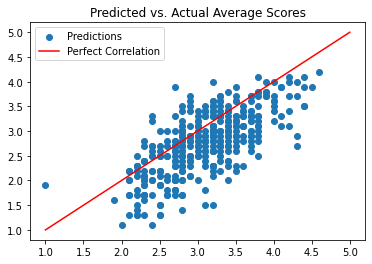

Results Saved -- Epoch: 2 | Train Loss:  0.594     | Val Loss:  0.681
Running Training


100%|██████████| 391/391 [06:52<00:00,  1.06s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]

[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

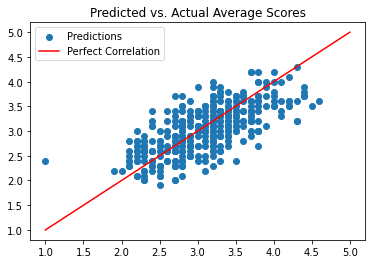

Results Saved -- Epoch: 3 | Train Loss:  0.552     | Val Loss:  0.571
Running Training


100%|██████████| 391/391 [06:52<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

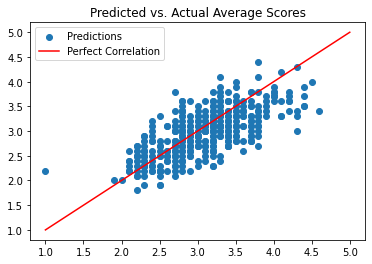

Results Saved -- Epoch: 4 | Train Loss:  0.517     | Val Loss:  0.564
Running Training


100%|██████████| 391/391 [06:52<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

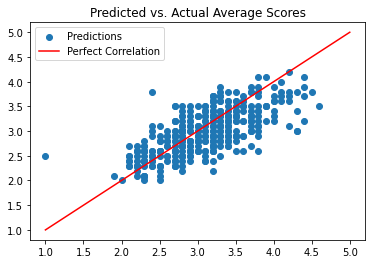

Results Saved -- Epoch: 5 | Train Loss:  0.488     | Val Loss:  0.548
Running Training


100%|██████████| 391/391 [06:52<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

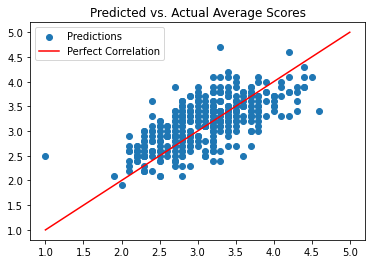

Results Saved -- Epoch: 6 | Train Loss:  0.475     | Val Loss:  0.560
Running Training


100%|██████████| 391/391 [06:52<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]

[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

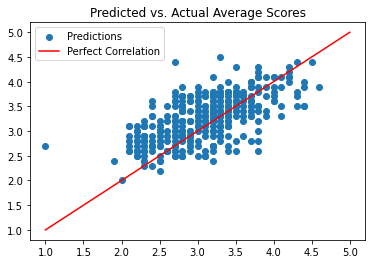

Results Saved -- Epoch: 7 | Train Loss:  0.461     | Val Loss:  0.589
Running Training


100%|██████████| 391/391 [06:52<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

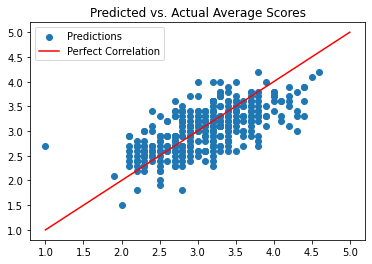

Results Saved -- Epoch: 8 | Train Loss:  0.442     | Val Loss:  0.545
Running Training


100%|██████████| 391/391 [06:52<00:00,  1.05s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

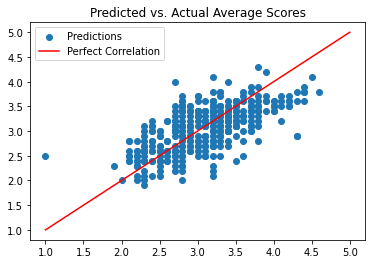

Results Saved -- Epoch: 9 | Train Loss:  0.422     | Val Loss:  0.549
Running Training


100%|██████████| 391/391 [06:52<00:00,  1.06s/it]


Running Validation


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]

[[2.5, 2.5, 2.0, 2.5, 2.5, 2.0], [3.0, 2.5, 3.5, 3.0, 3.0, 3.5], [3.0, 3.5, 3.5, 3.5, 3.0, 4.0], [2.5, 3.0, 3.0, 2.5, 2.5, 3.0], [3.5, 2.5, 3.0, 2.5, 3.5, 3.5], [3.5, 3.5, 3.0, 3.0, 2.5, 2.5], [4.0, 3.5, 3.5, 4.0, 3.5, 4.5], [3.0, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 4.0, 3.0, 4.0, 3.5, 3.0], [2.5, 2.0, 3.0, 2.5, 2.0, 2.0], [3.0, 3.0, 3.0, 3.5, 3.0, 3.0], [3.5, 3.0, 2.5, 3.0, 3.0, 3.0], [2.5, 2.5, 3.0, 3.0, 2.5, 3.5], [2.0, 2.0, 2.5, 2.0, 2.5, 2.0], [2.0, 2.0, 2.5, 1.5, 2.5, 2.5], [3.0, 2.0, 2.5, 2.5, 2.5, 2.5], [2.0, 2.5, 2.5, 2.5, 2.0, 2.5], [4.0, 3.5, 3.5, 3.5, 3.5, 3.0], [2.5, 3.0, 3.0, 3.0, 3.0, 2.5], [3.0, 2.5, 3.0, 2.5, 2.5, 2.5], [3.5, 3.0, 2.5, 3.5, 2.5, 2.5], [3.5, 3.0, 4.0, 3.0, 3.5, 3.0], [3.0, 3.0, 3.0, 3.0, 3.0, 2.5], [3.5, 2.5, 3.5, 3.0, 3.0, 3.0], [2.5, 3.5, 3.0, 3.5, 3.5, 3.0], [3.5, 3.0, 3.5, 3.5, 2.5, 3.0], [3.0, 3.5, 4.0, 3.5, 3.5, 3.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [3.0, 2.5, 3.0, 3.0, 3.0, 2.5], [3.5, 3.0, 3.0, 3.5, 3.0, 3.5], [2.5, 2.0, 2.0, 2.0, 2.0, 2.0], [3.0, 3

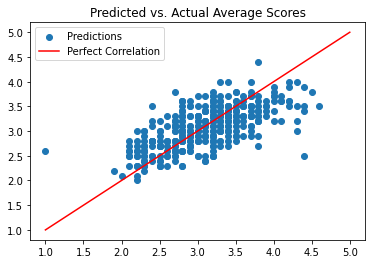

Results Saved -- Epoch: 10 | Train Loss:  0.407     | Val Loss:  0.536


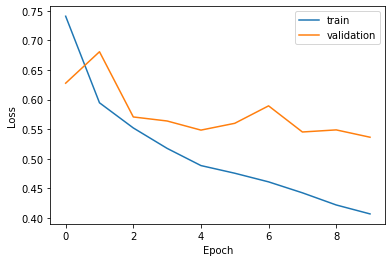

In [24]:
# Run the training on each provided set of hyperparameters

with torch.no_grad():
    torch.cuda.empty_cache()

parametersPath = '../input/hp-set1/hyperparameters-set-18.csv'
hyperparameters = pd.read_csv(parametersPath)

results = [] # For storing results

num_sets = len(hyperparameters.index)

for idx in range(num_sets):
    model_train(hyperparameters, idx, results)
    plot_train_val(idx, results)
    
    tokenizer_path = '../working/tokenizer' + str(idx + 1) + '.pt'
    model_path = '../working/model' + str(idx + 1) + '.pt'
    
    torch.save(tokenizer, tokenizer_path)
    torch.save(model, model_path)

In [25]:
#%%script false --no-raise-error

# Save the model

# os.mkdir('../working/model_2')

torch.save(tokenizer, '../working/tokenizer.pt')

torch.save(model, '../working/oneepoch.pt')


In [26]:
# Load the model
print(os.getcwd())
model = torch.load('../working/oneepoch.pt')
tokenizer = torch.load('../working/tokenizer.pt')

model.eval()

/kaggle/working


DebertaEvaluator(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (drop

In [27]:
# Set batch size to 1 for kaggle test run
batch_size = 1

In [28]:
# Build the test dataset class
class DatasetTest(torch.utils.data.Dataset):
    
    def __init__(self,df):
        self.ids = df.text_id.to_list()
        print(self.ids)
        self.texts = [tokenizer(text, padding='max_length', max_length = max_len,
                               truncation=True, return_tensors="pt") for text in df['full_text']]
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        
        return self.texts[idx], self.ids[idx]

In [29]:
# Make predictions on test set

testDataPath = '../input/feedback-prize-english-language-learning/test.csv'

df_test = pd.read_csv(testDataPath)
df_test.head()

test_dataset = DatasetTest(df_test)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

submission = [['text_id', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']]

with torch.no_grad():
    
    for test_input, test_id in test_dataloader:
        mask = test_input['attention_mask'].to(device)
        input_id = test_input['input_ids'].squeeze(1).to(device)
    
        # Loss
        output = model(input_id, mask).squeeze(1)
        
        predicted = torch.round(output * 10) / 2
        predicted = predicted.cpu().data.numpy()
        
        values = np.column_stack((test_id, predicted))
        for value in values:
            submission.append([value[0], value[1], value[2], value[3], value[4], value[5], value[6]])



['0000C359D63E', '000BAD50D026', '00367BB2546B']


In [30]:
# Writing to the submission file

import csv
with open('submission.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerows(submission)
    
print('Writing to submission file complete')

Writing to submission file complete
